In [1]:
repo_path = "/Users/johnzhou/research/decision-making"
expt_dir = f"{repo_path}/experiments"
data_dir = f"{repo_path}/data"

In [2]:
import sys
sys.path.append(repo_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch
from src.data.blocks import RealDataset, SynthDataset
from src.models.blockvae import BlockVAE
from src.models.agentnet import AgentNet
from src.models.sigmoidnet import SigmoidNet
from src.models.find_shapes import conv1d_shape, convtranspose1d_shape
from src.models.train import train
from src.features.build_features import sigmoid

In [4]:
vae_config = OmegaConf.create({
    "name": "test_expt",
    "random_seed": 4995,
    "model": {
        "in_channels": 1,
        "conv_encoder_layers": [[16, 3, 2], [8, 3, 2], [4, 1, 1]],
        "conv_decoder_layers": [[8, 3, 2, 0], [4, 2, 1, 0], [1, 1, 2, 0]],
        "encoder_output_dim": [4, 3],
        "latent_dim": 6,
        "use_batch_norm": True
    },
    "learning_rate": 1e-4,
    "data": {
        "feature_path": f"{repo_path}/data/synth/sim_features.npy",
        "label_path": f"{repo_path}/data/synth/sim_labels.npy",
        "train_proportion": 0.8,
        "train_batch_size": 100,
        "val_batch_size": 100
    },
    "trainer": {
        "gpus": 0,
        "max_epochs": 100
    },

})

OmegaConf.save(config=vae_config, f=f"{repo_path}/configs/model_configs/vae_train.yaml")

In [5]:
print(OmegaConf.to_container(vae_config))

{'name': 'test_expt', 'random_seed': 4995, 'model': {'in_channels': 1, 'conv_encoder_layers': [[16, 3, 2], [8, 3, 2], [4, 1, 1]], 'conv_decoder_layers': [[8, 3, 2, 0], [4, 2, 1, 0], [1, 1, 2, 0]], 'encoder_output_dim': [4, 3], 'latent_dim': 6, 'use_batch_norm': True}, 'learning_rate': 0.0001, 'data': {'feature_path': '/Users/johnzhou/research/decision-making/data/synth/sim_features.npy', 'label_path': '/Users/johnzhou/research/decision-making/data/synth/sim_labels.npy', 'train_proportion': 0.8, 'train_batch_size': 100, 'val_batch_size': 100}, 'trainer': {'gpus': 0, 'max_epochs': 100}}


In [6]:
classifier_config = OmegaConf.create({
    "name": "test_expt",
    "random_seed": 4995,
    "model": {
        "in_features": 15,
        "linear_layers": [8],
        "use_batch_norm": True
    },
    "learning_rate": 1e-4,
    "data": {
        "feature_path": f"{repo_path}/data/synth/sim_features.npy",
        "label_path": f"{repo_path}/data/synth/sim_labels.npy",
        "train_proportion": 0.8,
        "train_batch_size": 100,
        "val_batch_size": 100
    },
    "trainer": {
        "gpus": 0,
        "max_epochs": 100
    },

})

OmegaConf.save(config=classifier_config, f=f"{repo_path}/configs/model_configs/classifier_train.yaml")

In [7]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [8]:
system, trainer = train(
    SigmoidNet, 
    OmegaConf.to_container(classifier_config),
    experiment_dir=expt_dir,
    checkpoint_name="model")
val_losses = trainer.validate()

Global seed set to 4995
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | LinearClassifier | 157   
-------------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)
/Users/johnzhou/anaconda3/envs/yass/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /Users/johnzhou/research/decision-making/experiments/test_expt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


{'in_features': 15, 'linear_layers': [8], 'use_batch_norm': True}
LinearClassifier(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=8, out_features=3, bias=True)
  )
)
Validation sanity check:   0%|                            | 0/2 [00:00<?, ?it/s]

/Users/johnzhou/anaconda3/envs/yass/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Global seed set to 4995
/Users/johnzhou/anaconda3/envs/yass/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 0:  80%|████████▊  | 800/1000 [00:03<00:00, 215.25it/s, loss=nan, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 0:  96%|██████████▌| 960/1000 [00:03<00:00, 240.51it/s, loss=nan, v_num=4]
Epoch 0: 100%|█| 1000/1000 [00:04<00:00, 243.79it/s, loss=nan, v_num=4, val_loss
Epoch 0: 100%|█| 1000/1000 [00:04<00:00, 242.76it/s, loss=nan, v_num=4, val_loss


/Users/johnzhou/anaconda3/envs/yass/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `validate(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /Users/johnzhou/research/decision-making/experiments/test_expt/model-v1.ckpt
Loaded model weights from checkpoint at /Users/johnzhou/research/decision-making/experiments/test_expt/model-v1.ckpt



Validating: 0it [00:00, ?it/s]
Validating: 100%|████████████████████████████| 200/200 [00:00<00:00, 592.14it/s]--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': nan}
--------------------------------------------------------------------------------

                                                                                

In [9]:
net = SigmoidNet(OmegaConf.to_container(classifier_config))
model = net.load_from_checkpoint(f"{expt_dir}/test_expt/model-v1.ckpt")

{'in_features': 15, 'linear_layers': [8], 'use_batch_norm': True}
LinearClassifier(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=8, out_features=3, bias=True)
  )
)
{'in_features': 15, 'linear_layers': [8], 'use_batch_norm': True}
LinearClassifier(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=8, out_features=3, bias=True)
  )
)


In [10]:
blocks = np.load(f"{data_dir}/synth/sim_features.npy")
print(blocks.shape)

(100000, 15)


In [15]:
X_fname = f"{data_dir}/synth/sim_features.npy"
model_fname = f"{expt_dir}/test_expt/sigmoid.ckpt"
system = SigmoidNet

model = system.load_from_checkpoint(model_fname)

params = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(np.load(X_fname)).float(), 1)))
print(params.shape)

{'in_features': 15, 'linear_layers': [64, 32, 16, 8], 'use_batch_norm': True}
LinearClassifier(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.05)
    (5): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): LeakyReLU(negative_slope=0.05)
    (8): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=16, out_features=8, bias=True)
    (10): LeakyReLU(negative_slope=0.05)
    (11): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=8, out_features=3, bias=True)
  )
)
torch.Size([100000, 3])


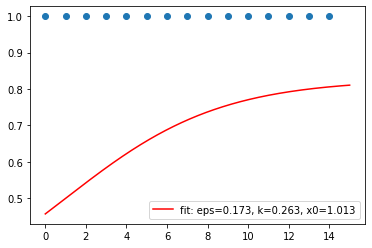

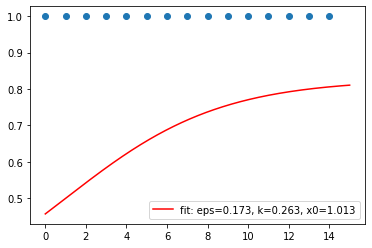

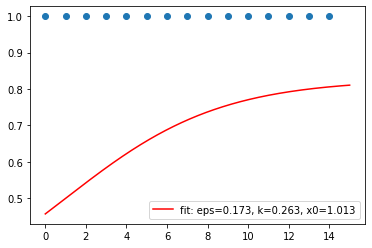

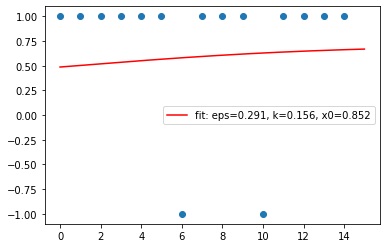

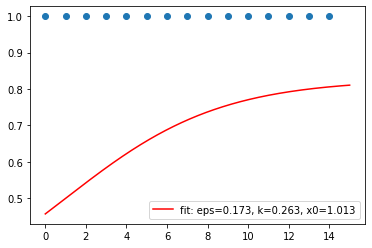

In [19]:
block_idxs = range(10000, 10500, 100)

for block_idx in block_idxs:
    block_params = params[block_idx, :].detach().numpy()
    block = blocks[block_idx, :]
    x_obs = range(15)

    plt.plot(np.linspace(0, block.size, num=1000),
             sigmoid(np.linspace(0, block.size, num=1000), *block_params), 'r-',
             label='fit: eps=%5.3f, k=%5.3f, x0=%5.3f' % tuple(block_params))
    plt.legend()
    plt.scatter(x_obs, block)
    plt.show()